# Introduction

Citibike is the leading bikesharing platform in New York, including the districts of Manhattan, Brooklyn, Queens & Jersey City. That said, the company is far from being profitable due to growing competition from other modes of transportation (e.g., scooters, electric bikes, etc.). According to a consulting firm hired a few months ago, the operations of Citibike are inefficient due to the lack of data-driven decision processes. If Citibike were only 4\% more efficient, it would become profitable. During peak hours (e.g., morning commute time), the bikesharing platform is particularly unreliable. Approximately 20\% of the dock stations face a "stock-out" situation, meaning that there are no bikes available. In such cases, commuters choose other modes of transportation. 

<img src="citi-bike.jpg" width="500">

### Your assignment
The consulting firm recommends using **optimization models** to improve the operations, especially during peak time. As part of this new strategy, you are recently hired as a lead data scientist of Citibike. You suspect that the inventory of bikes and the dock stations are not well positioned given the incoming demand at peak times. In this workshop, you will develop a data-driven optimization model to improve the positioning of inventory at peak time. In particular, you will formulate and implement integer programming models.

*Workshop instructions*: **Please carefully read all the instructions below:**
- The code cells are partially filled. You need to complete and execute the code in each cell. *You can consult any material posted on Canvas to help you get started with the syntax. You can ask questions to the TAs and discuss with your teammates.*
- Make sure to answer all the questions along the way in a detailed manner.
- This is an individual assignment; you should differentiate your coding style, answers, commenting, etc. from those of your teammates.
- Only Q1-Q3.6 are meant to be covered in class. You are free to start working on the other questions, but you should not exchange with your teammates on all remaining questions.

*Submission*: Your submission should include the following:
- *Notebook:* An html file along with a .ipynb file **(85 pt)**
- *Executive summary:* A 1 pager report summarizing all your findings (at least 11 pt font, 1 inch margin, pdf/doc format). This report should take the form of an executive summary that combines elements of your analysis and business recommendations. Supporting evidence can be provided in an appendix, or by referencing the questions of the workshop. The report will be evaluated along 3 dimensions: clarity, scientific validity, practical relevance. **(15 pt)**


# Q1. Visualize the data (15 pt)

## Load the data

Your colleague has generated data sets that contains all the needed information about the demand and available inventory of bikes during *one hour at peak time*. Your initial analysis will be based on the following data sets:

- `demand.csv`: describes the number of bikes rented at each dock station (during one peak hour),
- `starting_inventory.csv`: describes the initial inventory of bikes at each dock station (before peak hour),
- `distances.csv`: describes the distance between any two dock stations (in km unit).


Ideally, the inventory of bikes available the beginning of the peak hour should approximately match the expected amount of demand. For example, if you expect 5 user requests in station A, and 5 user requests in station B in the next hour, the number of bikes in station A and B should be roughly equal, otherwise there is an imbalance of inventory. Using spatial visualization, you will check if the initial inventory is balanced or imbalanced.

*Execute the cells below. Read carefully all the comments*

In [2]:
# Import various packages
import pandas as pd
import numpy as np
import folium # visualisation package for spatial data (plot of maps)
import seaborn as sns # general visualization package  
import matplotlib.pyplot as plt # general visualization package 
#next command allows you to display the figures in the notebook
%matplotlib inline     

In [2]:
## In case folium is not installed, run the command below and import folium again
# ! conda install -c conda-forge folium --yes

Solving environment: | 
The environment is inconsistent, please check the package plan carefully
The following packages are causing the inconsistency:

  - defaults/osx-64::_anaconda_depends==2020.07=py38_0
  - defaults/osx-64::anaconda==custom=py38_1
done

## Package Plan ##

  environment location: /Users/alex/opt/anaconda3

  added / updated specs:
    - folium


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    branca-0.4.2               |     pyhd8ed1ab_0          26 KB  conda-forge
    certifi-2021.10.8          |   py38h50d1736_1         145 KB  conda-forge
    conda-4.11.0               |   py38h50d1736_0        16.9 MB  conda-forge
    folium-0.12.1.post1        |     pyhd8ed1ab_1          64 KB  conda-forge
    python_abi-3.8             |           2_cp38           4 KB  conda-forge
    ------------------------------------------------------------
                                

Next, you need to load the data sets as dataframes using the Pandas function `pd.read_csv()`.

In [3]:
starting_inventory = pd.read_csv("starting_inventory.csv", index_col=0) 
# "index_col=0" is used so that the dataframe is indexed by the first column, which is the dock station ID
demand = pd.read_csv("demand.csv", index_col=0) 
distances = pd.read_csv("distances.csv", index_col=0)
distances.columns = list(map(lambda x: int(x),distances.columns.tolist())) # the column names (dock IDs) are converted into integers
replenishment = pd.read_csv("replenishment.csv", index_col=0)


Using the command `.describe()`, you can familiarize yourself with the format of the dataframes, and  check if there are missing entries.

In [63]:
# Insert your code here
# starting_inventory.describe() #there is count of bikes at each station and long + lat
# starting_inventory.head()
# demand.describe()
# demand.head() # long lat and count, similar mean count to starting inv
# distances.describe()
# distances.head() #shows all possible combos of distances between stations in matrix style
# replenishment.describe()
# replenishment.head()


,count,latitude,longitude
count,689.000000,689.000000,689.000000
mean,30.724238,40.732527,-73.967780
std,70.308432,0.041163,0.024024
min,10.000000,40.655400,-74.025353
25%,10.000000,40.695807,-73.987030
50%,10.000000,40.728419,-73.968044
75%,19.000000,40.767100,-73.949450
max,739.000000,40.814394,-73.910651


### Q1.0. What is the distance between the dock stations "120" and "146"? What is the maximum inventory of bikes initially available over all dock stations?

In [25]:
# np.max(starting_inventory["count"])

739

The distance between dock station 120 and 146 is 5.789km.

The maximum number of inventory of bikes available over all dock stations is 739.

## Plot the heatmaps of demand and inventory

In the next cells, we will generate a heatmap of New York, representing the level of demand in different regions.

*The code is provided. Feel free to experiment with different parameters to better understand their respective roles.*

In [4]:
def generateBaseMap(default_location=[40.71, -73.96], default_zoom_start=12.5):
    '''
    This function generates a base map using the folium package
    
    Arguments:
    default_location -> latitude, longitude (a list)
    default_zoom_start -> level of zoom of the map (a positive number)
    '''
    base_map = folium.Map(location=default_location,control_scale=True, zoom_start=default_zoom_start)
    # 'Stamen Toner' is a type of map; by default the map is "OpenStreetMap"
    return base_map

The next cell will plot a heatmap of the demand.

In [32]:
# Import the HeatMap object constructor from the folium package
from folium.plugins import HeatMap 

# To begin, generate a base map, which will be edited next
base_map = generateBaseMap()

# The demand is converted into a list of t-uples, each describing one request point: (longitude, latitude, count)
# Copy the demand dataframe 
demand_agg = demand.copy()
# Rounding latitudes and longitudes to nearest 0.001 decimal
demand_agg.loc[:,['latitude', 'longitude']] = demand_agg.loc[:,['latitude', 'longitude']].round(3)
# Aggregating by latitude and longitude 
demand_agg= demand_agg[['latitude', 'longitude', 'count']].groupby(['latitude', 'longitude']).sum()
# Converting demand into a list
demand_list = demand_agg.reset_index().values.tolist()

# Add the desired heatmap to the base map
HeatMap(data= demand_list,radius=0, max_zoom=15,minOpacity=0).add_to(base_map)
base_map

Ideally, you would like to compare the expected demand to the initial inventory at the dock stations. To this end, you need to visualize the inventory of bikes initially available.

*By re-using the code above, construct a heatmap for the inventory of bikes in the city (`starting_inventory`). You need to edit the lines of code relative to the construction of the demand list.*

In [22]:
# Uncomment and fill the code below

from folium.plugins import HeatMap
base_map = generateBaseMap()
inventory_agg = starting_inventory.copy()
# Create a line of code to round latitudes and longitudes
inventory_agg.loc[:,['latitude', 'longitude']] = inventory_agg.loc[:,['latitude', 'longitude']].round(3)
# Create a line of code to aggregate the inventory by latitudes and longitudes
inventory_agg = inventory_agg[['latitude', 'longitude', 'count']].groupby(['latitude', 'longitude']).sum()
# Convert inventory_agg to a list inventory_list (fill below)
inventory_list = inventory_agg.reset_index().values.tolist()
HeatMap(data= inventory_list,radius=0, max_zoom=15,minOpacity=0).add_to(base_map)
base_map


### Q1.1. Are there apparent mismatches between demand and inventory as you compare the two heatmaps?

*Insert answer here:* 

Yes there is a mismatch between demand and supply. 
There seems to be more demand in lower manhattan/wall street area than there is inventory. This is highlighted in Franklin street area.

Around Pennsylvania station there are quite a few pockets of demand with little or no inventory in that area.

Your colleagues argue that that it is difficult to eyeball the differences between the two heatmaps. It would be preferable to have a single heatmap showing the "imbalance" between demand and inventory. Specifically, you would like to identify  areas where the initial bike inventory is either insufficient or excessive, compared to the amount of demand.

### Q1.2. How can you quantify  the degree of imbalance between demand and inventory? Create heatmaps for the newly defined imbalance metric(s) showing the areas with lack or excess of bikes.

*Hint:* Define two new metrics that quantify the imbalance between demand inventory and reuse the same code as above: 
- The first metric could capture the deficit of inventory at the stations where demand_agg > inventory_agg,
- The second metric could capture the excess of inventory at the stations where inventory_agg > demand_agg.

*Insert answer here:*

The first metric caputring the deficit would be demand - inventory at each station. This will tell us the unmet demand at each station and could guide relocation to the stations with more demand.

The 2nd metric capturing the excess inventory would be inventory - demand. This would show the stations where there are more bikes than needed.

In [23]:
# Uncomment and fill the code below

base_map = generateBaseMap()
deficit = np.maximum(0,demand_agg - inventory_agg)
deficit_list = deficit.fillna(0).reset_index().values.tolist()
HeatMap(data= deficit_list,radius=0, max_zoom=15,minOpacity=0).add_to(base_map)
base_map

In [24]:
# Uncomment and fill the code below

# base_map = generateBaseMap()
excess = np.maximum(0,inventory_agg-demand_agg)
excess_list = excess.fillna(0).reset_index().values.tolist()
HeatMap(data= excess_list,radius=0, max_zoom=15,minOpacity=0).add_to(base_map)
base_map

### Q1.3. Add one more visualization of your own. Describe what it shows and what your learn from it in 1-2 lines

*Insert answer here:*

The histogram of replishement shows the distribution of replenishment or the number of extra bikes made available after users finish their rides. We can see that the majority of stations only get a replenishment in the range of 0 to 15. This gives us an indictation that most of the stations are of a size less than 30 as they only recieve this level of replenishment. There are only a few outlier stations that recieve higher replenishment levels from users

Text(0, 0.5, 'Extra bikes available after users replenish')

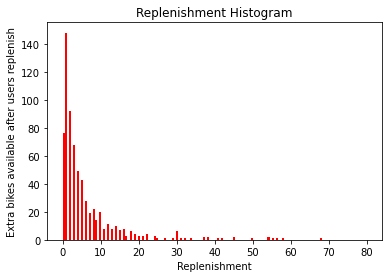

In [120]:
# Insert your code here
#replenishment
plt.hist(replenishment['count'], bins=150, range = [0, 80], color = "red")
plt.title("Replenishment Histogram")
plt.xlabel("Replenishment")
plt.ylabel("Extra bikes available after users replenish")


# Q2. Optimal Rebalancing of Bike Inventory (20 pt)

**Matching supply with demand**: Given the imbalances between demand and inventory, Citibike runs frequent "rebalancing" operations, where bikes are relocated from a dock station having an excess of inventory to a station having insufficient inventory. These rebalancing operations are run in an ad-hoc fashion. You would like to construct an optimization model to rigorously rebalance the inventory before the beginning of the peak hour.

**The economics of rebalancing:** Rebalancing operators have to be paid \\$1 per km per relocated bike. There are no geographical restrictions on the rebalancing of bikes (from any station to any other station). After the rebalancing is performed, the amount of demand satisfied at each station will the minimum between the new initial inventory level and the total demand (we assume that there is no further replenishment during the peak hour). Each satisfied user request brings \\$4 of revenue, on average. Hence, when bikes are unavailable and user requests are unfulfilled, Citibike loses the revenue opportunity of \\$4 per user. 

*In what follows, you will formulate and implement the rebalancing problem as an integer program. Starting with the inventory levels of `starting_inventory`, you want to find the bikes relocations that maximize the total net revenue. For simplicity, you can assume that the rebalancing operations happen instantaneously before the beginning of the peak hour. There is no increase in the supply of bikes during the peak hour.*

In [5]:
# The following lines of code import the gurobi package
import gurobipy as gp
from gurobipy import GRB,quicksum

## Model creation

### Q2.1. Create a GUROBI new model "m", named "rebalancing"

In [7]:
#Insert your code here:
m=gp.Model('rebalancing')

## Decision variables

Clearly your main decisions have to do with the "relocation" of bikes.

In [8]:
# Instantiate the list of all stations
stations = demand.index.tolist()

# Next, we create am "integer" decision variable for each pair of dock stations (A,B)
relocation = m.addVars(stations,stations,vtype=GRB.INTEGER, lb = 0, name="relocation")

### Q2.2. Explain in detail what the code in the cell above is doing.

*Insert your answer here:*

The code is getting a list of all the stations from the demand dataframe by extracting the index. 
Next we create a decision variable for the quantity of bikes relocated between each station pair. It shows from which station to which station and the number of bikes between those stations.

Your colleague thinks that additional decision will be needed for the problem. She suggests the following line of code:

In [9]:
satisfied_demand = m.addVars(stations,vtype=GRB.INTEGER, lb = 0, name="satisfied_demand")

### Q2.3. Why are the variables `satisfied_demand` needed? How do we refer to such variables (which do not describe actual decisions)?

*Insert your answer here:*

It is an auxilliary variable that shows how much demand is satisfied in a given station. The satisfied demand will be the minimum between the new initial inventory level after relocation and the total demand. It is needed as a modelling trick to take into account how much demand is satisfied at each station. Without this we wouldn't be able to take into account the difference between new inventory levels and total demand.

## Constraints

### Q2.4. Is there an upper bound on the number of bikes that can be relocated from one station to another? Incorporate the upper bound into the model.
*Hint: Use `starting_inventory.loc[i,"count"]` to access the initial number of bikes at station `i`.*

*Insert your answer here:*

The upper bound on the number of bikes that can be relocated should be the initial inventory level of bikes at a given station. 

In [10]:
#Insert your code here:
m.addConstrs((quicksum(relocation[i,s] for s in stations) <=  starting_inventory.loc[i,"count"]  for i in stations),"upperbound")
             
             
             

{119: <gurobi.Constr *Awaiting Model Update*>,
 120: <gurobi.Constr *Awaiting Model Update*>,
 127: <gurobi.Constr *Awaiting Model Update*>,
 143: <gurobi.Constr *Awaiting Model Update*>,
 144: <gurobi.Constr *Awaiting Model Update*>,
 146: <gurobi.Constr *Awaiting Model Update*>,
 150: <gurobi.Constr *Awaiting Model Update*>,
 157: <gurobi.Constr *Awaiting Model Update*>,
 161: <gurobi.Constr *Awaiting Model Update*>,
 167: <gurobi.Constr *Awaiting Model Update*>,
 173: <gurobi.Constr *Awaiting Model Update*>,
 174: <gurobi.Constr *Awaiting Model Update*>,
 195: <gurobi.Constr *Awaiting Model Update*>,
 2000: <gurobi.Constr *Awaiting Model Update*>,
 2002: <gurobi.Constr *Awaiting Model Update*>,
 2003: <gurobi.Constr *Awaiting Model Update*>,
 2005: <gurobi.Constr *Awaiting Model Update*>,
 2009: <gurobi.Constr *Awaiting Model Update*>,
 2012: <gurobi.Constr *Awaiting Model Update*>,
 2017: <gurobi.Constr *Awaiting Model Update*>,
 2021: <gurobi.Constr *Awaiting Model Update*>,
 2022

The satisfied demand in each station is the minimum between the demand and the inventory after rebalancing. For example, if station A has 10 bikes before the relocation and we relocate 2 extra bikes, we can satisfy up to 12 users. If the demand at station A is 8, we satisfy all 8 users. If the demand at station A is 15, we can only satisfy 12 users, and we lose 3 user requests. In general, we have the equation:

$$ {\rm satisfiedDemand}(A) ={\rm minimum} \left\{ {\rm InventoryAfterRebalancing}(A), {\rm Demand}(A)\right\}$$

Below, you will add two ensembles of constraints to our model `m` to capture the notion of satisfied demand.

### Q2.5. Add constraints imposing that `satisfied_demand` is smaller or equal to the demand, in each station.

In [11]:
#Insert your code here:
m.addConstrs((satisfied_demand[i] <= demand.loc[i,"count"] for i in stations), "se_than_demand")

{119: <gurobi.Constr *Awaiting Model Update*>,
 120: <gurobi.Constr *Awaiting Model Update*>,
 127: <gurobi.Constr *Awaiting Model Update*>,
 143: <gurobi.Constr *Awaiting Model Update*>,
 144: <gurobi.Constr *Awaiting Model Update*>,
 146: <gurobi.Constr *Awaiting Model Update*>,
 150: <gurobi.Constr *Awaiting Model Update*>,
 157: <gurobi.Constr *Awaiting Model Update*>,
 161: <gurobi.Constr *Awaiting Model Update*>,
 167: <gurobi.Constr *Awaiting Model Update*>,
 173: <gurobi.Constr *Awaiting Model Update*>,
 174: <gurobi.Constr *Awaiting Model Update*>,
 195: <gurobi.Constr *Awaiting Model Update*>,
 2000: <gurobi.Constr *Awaiting Model Update*>,
 2002: <gurobi.Constr *Awaiting Model Update*>,
 2003: <gurobi.Constr *Awaiting Model Update*>,
 2005: <gurobi.Constr *Awaiting Model Update*>,
 2009: <gurobi.Constr *Awaiting Model Update*>,
 2012: <gurobi.Constr *Awaiting Model Update*>,
 2017: <gurobi.Constr *Awaiting Model Update*>,
 2021: <gurobi.Constr *Awaiting Model Update*>,
 2022

### Q2.6. Explain what the additional constraints below on the `satisfied_demand`  are doing. Why they are needed?

*Insert your answer here:*

Satisfied demand should be less than equal to the starting inventory in the station itself plus the delta of all reallocation between the station. The station gains bikes from relocation from other stations and loses bikes by relocating some of its bikes to the other stations. These changes need to be taken into account with the starting inventory


In [12]:
# Additional constraints
m.addConstrs((satisfied_demand[i] <= starting_inventory.loc[i,"count"] \
              + quicksum(relocation[j,i] for j in stations) -quicksum(relocation[i,j] for j in stations)
                  for i in stations),name = "satisfied_demand_vs_inventory_after_rebalancing");

## Objective

### Q2.7. How would you formulate the net revenue as a linear expression? Specify the objective of the model.

*Hint: Recall that the objective function is specified using:* `m.setObjective(EXPRESSION,GRB.MAXIMIZE)`

*Insert your answer here:* 


In [13]:
#Insert your code here:
# $4 from each bike = demand
#$1 for each bike per km

# Option 1 tries to take into the cost of both:
#bikes station is losing
#bikes station is gaining

#Option 1 # m.setObjective(quicksum(4*satisfied_demand[i] for i in stations) -quicksum(relocation[i,j]*distances.loc[i,j] + relocation[j,i]*distances.loc[j,i] for j in stations for i in stations), GRB.MAXIMIZE)

# My worry however is that it double counts the relocations and hence have
# gone with Option 2 below

m.setObjective(quicksum(4*satisfied_demand[i] for i in stations)-quicksum(relocation[i,j]*distances.loc[i,j] for i in stations for j in stations), GRB.MAXIMIZE)
               

## Solve

Congratulations! You have formulated and implemented the integer program. You can now optimize the rebalancing and printout the optimal revenue/

In [14]:
# Run the optimization
# Note: it is not convenient to printout the relocation solution. We will develop a suitable visualization tool.
def printSolution():
    if m.status == GRB.OPTIMAL:
        print('\nNet revenue: %g' % m.objVal)
    else:
        print('No solution:', m.status)
        
m.optimize()
printSolution()

Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[x86])
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 2067 rows, 475410 columns and 1424163 nonzeros
Model fingerprint: 0x705b3843
Variable types: 0 continuous, 475410 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-04, 2e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 7e+02]
Found heuristic solution: objective 62468.000000
Presolve removed 689 rows and 19978 columns
Presolve time: 4.18s
Presolved: 1378 rows, 455432 columns, 1337358 nonzeros
Variable types: 0 continuous, 455432 integer (6671 binary)
Found heuristic solution: objective 62739.189353

Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    7.5668248e+04   6.256250e+02   0.000000e+00      5s

Starting sifting (using dual simplex for sub-problems)...

    Iter     Pivots    Primal Obj      Dual Obj        Time


### Q2.8. Read the output of the optimization: What is the optimal net revenue?

*Insert your answer here:* 
The optimal net revenue is 71314.1.




### Q2.9. How much revenue does Citibike gain using the optimal rebalancing compared to no rebalancing? Is this a significant increase? Carefully explain how you obtain the answer (feel free to add code below).
*Hint: The goal here is to quantity how the revenue changes after the optimal rebalancing vs. no rebalancing. To compute the revenue in the absence of rebalancing, you could reuse our optimization model with a small modification of the variables `relocation`.*

In [18]:
# no_reloc = m.addConstrs(relocation[i,j] <=0 for i in stations for j in stations)
# m.remove(no_reloc)

In [19]:

# Run the optimization
# Note: it is not convenient to printout the relocation solution. We will develop a suitable visualization tool.
def printSolution():
    if m.status == GRB.OPTIMAL:
        print('\nNet revenue: %g' % m.objVal)
    else:
        print('No solution:', m.status)
        
m.optimize()
printSolution()

Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[x86])
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 2067 rows, 475410 columns and 1424163 nonzeros
Model fingerprint: 0x705b3843
Variable types: 0 continuous, 475410 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-04, 2e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 7e+02]

Loaded MIP start from previous solve with objective 62468

Presolve removed 689 rows and 19978 columns
Presolve time: 4.31s
Presolved: 1378 rows, 455432 columns, 1337358 nonzeros
Variable types: 0 continuous, 455432 integer (6671 binary)
Found heuristic solution: objective 62739.189353

Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    7.5668248e+04   6.256250e+02   0.000000e+00      5s

Starting sifting (using dual simplex for sub-problems)...

    Iter     Pivots    Primal Obj      Dual Obj  

*Insert your answer here:*

To see the difference between optimal rebalancing and no rebalancing we can make a constraint that relocation must be less than or equal to zero. This will force there to be no relocation. The optimization can be run again and the revenue differences can be compared. The Net revenue for no rebalancing is 62468. They gain 8,846.1 in revenue. This is more than 10% and quite a significant increase.

The relocations are visualized on the heatmap in the next cell. 

*Code is provided, Execute the next cells. Feel free to vary the parameters to understand their role.*

In [25]:
from collections import namedtuple
def get_bearing(p1, p2):
    
    '''
    Returns compass bearing from p1 to p2
    
    Parameters
    p1 : namedtuple with lat lon
    p2 : namedtuple with lat lon
    
    Return
    compass bearing of type float
    
    Notes
    Based on https://gist.github.com/jeromer/2005586
    '''
    
    long_diff = np.radians(p2.lon - p1.lon)
    
    lat1 = np.radians(p1.lat)
    lat2 = np.radians(p2.lat)
    
    x = np.sin(long_diff) * np.cos(lat2)
    y = (np.cos(lat1) * np.sin(lat2) 
        - (np.sin(lat1) * np.cos(lat2) 
        * np.cos(long_diff)))
    bearing = np.degrees(np.arctan2(x, y))
    
    # adjusting for compass bearing
    if bearing < 0:
        return bearing + 360
    return bearing
def get_arrows(locations, color='black', size=4, n_arrows=3,opacity = 1):
    
    '''
    Get a list of correctly placed and rotated 
    arrows/markers to be plotted
    
    Parameters
    locations : list of lists of lat lons that represent the 
                start and end of the line. 
                eg [[41.1132, -96.1993],[41.3810, -95.8021]]
    arrow_color : default is 'blue'
    size : default is 6
    n_arrows : number of arrows to create.  default is 3
    Return
    list of arrows/markers
    '''
    
    Point = namedtuple('Point', field_names=['lat', 'lon'])
    
    # creating point from our Point named tuple
    p1 = Point(locations[0][0], locations[0][1])
    p2 = Point(locations[1][0], locations[1][1])
    
    # getting the rotation needed for our marker.  
    # Subtracting 90 to account for the marker's orientation
    # of due East(get_bearing returns North)
    rotation = get_bearing(p1, p2) - 90
    
    # get an evenly space list of lats and lons for our arrows
    # note that I'm discarding the first and last for aesthetics
    # as I'm using markers to denote the start and end
    arrow_lats = np.linspace(p1.lat, p2.lat, n_arrows + 2)[1:n_arrows+1]
    arrow_lons = np.linspace(p1.lon, p2.lon, n_arrows + 2)[1:n_arrows+1]
    
    arrows = []
    
    #creating each "arrow" and appending them to our arrows list
    for points in zip(arrow_lats, arrow_lons):
        arrows.append(folium.RegularPolygonMarker(location=points, 
                      fill_color=color, color = color, number_of_sides=3, 
                      radius=size, rotation=rotation,opacity = opacity))
    return arrows

base_map = generateBaseMap() # generates our base map of NY
# Next we compute the imbalance between demand and inventory
imbalance = np.divide(demand_agg,1+inventory_agg)
imbalance_list = imbalance.fillna(0).reset_index().values.tolist()


# The next loop plots the relocation lines between any two stations.
# The more opaque is the line, the more relocations are made
for i in stations:
    for j in stations:
        if relocation[i,j].x >0:
            p1 = [demand.loc[i,"latitude"],demand.loc[i,"longitude"]]
            p2 = [demand.loc[j,"latitude"],demand.loc[j,"longitude"]]
            opacity = relocation[i,j].x/starting_inventory.loc[i,"count"] +relocation[i,j].x/20
            folium.PolyLine(locations=[p1, p2], color='black', opacity = opacity).add_to(base_map)
            arrows = get_arrows(locations=[p1, p2],color='black', n_arrows=1,opacity = opacity)
            for arrow in arrows:
                arrow.add_to(base_map)

#Plots the heatmap
HeatMap(data= imbalance_list,radius=0,max_zoom=15,minOpacity=0).add_to(base_map)

#Displays the map
base_map       

### Q2.10. How do you interpret the plot? Is this what you would expect?

*Insert your answer:* 

The plot shows the hotspots where demand/inventory is high for the bikes and the arrows show the relocations of bikes. From my understanding of the plot, it seems to be what I expected. A lot of the arrows are pointing to the demand hotspots from areas that don't have as much demand. Even on the outer areas of the city, there are arrows going from areas with little to no blue shading to areas with more. The shading from blue to red represents demand.


# Q3. Rebalancing with replenishment (20 pt)

You manager has a concern about your analysis in Q2:

*I like the idea of rebalancing bikes based on an optimization model. However, you have omitted an important aspect of the problem. When a user completes her current trip, she returns the bike to the system. A new bike is made available at the destination station. You don't account for this in your current inventory, but this organic replenishment of bikes might be very helpful since it increases the number of bikes available at the destination station!*

The goal of Q3 is to update the model accordingly. You will reuse most of the existing code, with minor modifications.  Your analysis will be based on the following additional data set:

- `replenishment.csv`: describes the number of extra bikes that will be made available at each station after current users complete their trips. 

**For simplicity, we will assume that the replenishment happens instantaneously before the beginning of the peak hour.**

### Q3.1. Based on your manager's comment, did you under-estimate or over-estimate the inventory at each station in the previous question Q2?

*Insert your answer here:* 

As we didn't take into account the replenishment, we underestimated the inventory at each station. This is because if someone takes a bike from station 12 to station 14 it is important to add the bike to station 14 to the initial inventory of station 14. 

## Loading the data

In [29]:
replenishment = pd.read_csv("replenishment.csv", index_col=0)

*You can visualize the replenishment data using `.describe()`.*

In [30]:
replenishment.describe()
replenishment.head()

,latitude,longitude,count
station_id,,,
119,10,-18,1
120,10,-18,2
127,10,-18,42
143,10,-18,3
144,10,-18,1


## Model creation

### Q3.2 Create the model object

*Hint: Reuse the same code as Q2.1.*

In [35]:
#Insert your code here:
m=gp.Model('rebalancing')

## Decision variables

### Q3.2. Add the decision variables to `m`
*Hint: Reuse the same code as Q2.2 and Q2.3*

In [126]:
#Insert your code here:

relocation = m.addVars(stations,stations,vtype=GRB.INTEGER, lb = 0, name="relocation")
satisfied_demand = m.addVars(stations,vtype=GRB.INTEGER, lb = 0, name="satisfied_demand")

## Constraints

### Q3.3. Add an upper bound on the number of bikes that can be relocated from one station to another.
*Hint: Reuse the same code as Q2.4*

In [127]:
#Insert your code here:
m.addConstrs((quicksum(relocation[i,s] for s in stations) <=  starting_inventory.loc[i,"count"]  for i in stations),"upperbound")

{119: <gurobi.Constr *Awaiting Model Update*>,
 120: <gurobi.Constr *Awaiting Model Update*>,
 127: <gurobi.Constr *Awaiting Model Update*>,
 143: <gurobi.Constr *Awaiting Model Update*>,
 144: <gurobi.Constr *Awaiting Model Update*>,
 146: <gurobi.Constr *Awaiting Model Update*>,
 150: <gurobi.Constr *Awaiting Model Update*>,
 157: <gurobi.Constr *Awaiting Model Update*>,
 161: <gurobi.Constr *Awaiting Model Update*>,
 167: <gurobi.Constr *Awaiting Model Update*>,
 173: <gurobi.Constr *Awaiting Model Update*>,
 174: <gurobi.Constr *Awaiting Model Update*>,
 195: <gurobi.Constr *Awaiting Model Update*>,
 2000: <gurobi.Constr *Awaiting Model Update*>,
 2002: <gurobi.Constr *Awaiting Model Update*>,
 2003: <gurobi.Constr *Awaiting Model Update*>,
 2005: <gurobi.Constr *Awaiting Model Update*>,
 2009: <gurobi.Constr *Awaiting Model Update*>,
 2012: <gurobi.Constr *Awaiting Model Update*>,
 2017: <gurobi.Constr *Awaiting Model Update*>,
 2021: <gurobi.Constr *Awaiting Model Update*>,
 2022

### Q3.4. Add constraints requiring that `satisfied_demand` is smaller or equal to the demand.
*Hint: Reuse the same code as Q2.5*

In [128]:
#Insert your code here:
m.addConstrs((satisfied_demand[i] <= demand.loc[i,"count"] for i in stations), "se_than_demand")

{119: <gurobi.Constr *Awaiting Model Update*>,
 120: <gurobi.Constr *Awaiting Model Update*>,
 127: <gurobi.Constr *Awaiting Model Update*>,
 143: <gurobi.Constr *Awaiting Model Update*>,
 144: <gurobi.Constr *Awaiting Model Update*>,
 146: <gurobi.Constr *Awaiting Model Update*>,
 150: <gurobi.Constr *Awaiting Model Update*>,
 157: <gurobi.Constr *Awaiting Model Update*>,
 161: <gurobi.Constr *Awaiting Model Update*>,
 167: <gurobi.Constr *Awaiting Model Update*>,
 173: <gurobi.Constr *Awaiting Model Update*>,
 174: <gurobi.Constr *Awaiting Model Update*>,
 195: <gurobi.Constr *Awaiting Model Update*>,
 2000: <gurobi.Constr *Awaiting Model Update*>,
 2002: <gurobi.Constr *Awaiting Model Update*>,
 2003: <gurobi.Constr *Awaiting Model Update*>,
 2005: <gurobi.Constr *Awaiting Model Update*>,
 2009: <gurobi.Constr *Awaiting Model Update*>,
 2012: <gurobi.Constr *Awaiting Model Update*>,
 2017: <gurobi.Constr *Awaiting Model Update*>,
 2021: <gurobi.Constr *Awaiting Model Update*>,
 2022

 ### Q3.5. The `satisfied_demand` should be also be related to inventory. How would you modify the constraint of Q2.6 to account for replenishment? Add these constraints to the model.
 
 *Hint: You should use the same constraint as Q2.6, but also incorporate the replenishment quantity. For simplicity, you can assume that all the replenishment happens before the demand arrives. This assumption is reasonable if the system is "stationary".*

*Insert your answer here:*

The replenishment quantity is added to the starting inventory and the delta of all the relocations from and to a given station. This is done by adding replenishment.loc[i,"count"]





In [129]:
#Insert your code here:
m.addConstrs((satisfied_demand[i] <= starting_inventory.loc[i,"count"]+replenishment.loc[i,"count"] \
              + quicksum(relocation[j,i] for j in stations) -quicksum(relocation[i,j] for j in stations)
                  for i in stations),name = "satisfied_demand_vs_inventory_after_rebalancing_and_replenishing");

## Objective

### Q3.6. What is the objective function? Specify the objective of the model `m`.

*Hint: Reuse the code of Q2.7*

In [130]:
#Insert your code here:
m.setObjective(quicksum(4*satisfied_demand[i] for i in stations)-quicksum(relocation[i,j]*distances.loc[i,j] for i in stations for j in stations), GRB.MAXIMIZE)

*Insert your answer here:* 

It is the same objective function as before. We want to maximize the net revenue. The net revenue takes into account the reallocation costs.

## Solve

Congratulations! You have formulated and implemented the integer program. You can now optimize the rebalancing and printout the optimal revenue.

In [131]:
# Run the optimization
# Note: it is not convenient to printout the relocation solution. We will develop a suitable visualization tool.
def printSolution():
    if m.status == GRB.OPTIMAL:
        print('\nNet revenue: %g' % m.objVal)
    else:
        print('No solution:', m.status)
        
m.optimize()
printSolution()

Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[x86])
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 1428297 rows, 3324425 columns and 6171373 nonzeros
Model fingerprint: 0x41f0db24
Variable types: 0 continuous, 3324425 integer (474721 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+06]
  Objective range  [1e-04, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+06]

Processing MIP start from previous solve: 0 nodes explored in subMIP, total elapsed time 5s
MIP start from previous solve produced solution with objective 75662.9 (8.10s)
Loaded MIP start from previous solve with objective 75662.9
Processed MIP start in 8.38 seconds (10.83 work units)

Presolve removed 1425541 rows and 2375672 columns (presolve time = 5s) ...
Presolve removed 1426976 rows and 2884440 columns (presolve time = 10s) ...
Presolve removed 1426952 rows and 2884416 columns
Presolve time: 10.09s
Presolved: 1345 rows, 4400

### Q3.7. Read the output of the optimization: What is the optimal net revenue? Is it greater or smaller than that obtained without replenishment in question Q.2.8? Why?

*Insert your answer here:* 

The optimal revenue is 75662.9. This is greater than the revenue obtained without replenishment in Q2.8. This is because there are less costs needed to transport the replenished biked. Previously they needed to be relocated which incurred extra costs. Some of the replenished bikes now may not need to be relocated, saving costs. 

### Q3.8. How much revenue does Citibike gain using the optimal rebalancing compared to no rebalancing? How does this compare to Q2.9? Why?
*Hint: The goal here is to quantity the revenue change after vs. before the optimal rebalancing. To compute the revenue in the absence of rebalancing, you could reuse our optimization model with a very small modification of the variables `relocation`.*

*Insert your answer here:*

72024 is the revenue with no rebalancing. They gain 3,638.9. This is a smaller gain than in Q2.9. For Q2.9 replenishment was not taken into account which led to more relocation. With the replenishment being incorporated in Q3 this means that there is potentially less need for relocation and hence the difference between optimal rebalancing and no rebalancing is smaller. As seen by the map, there is a lot less relocation happening which would explain why the gain between no relocation and optimal relocation is much smaller.  


In [44]:
# no_reloc = m.addConstrs(relocation[i,j] <=0 for i in stations for j in stations)
# m.remove(no_reloc)

The relocations are visualized on the heatmap in the next cell. *Execute the next cell.*

In [55]:
base_map = generateBaseMap() # generates our base map of NY
# Next we compute the imbalance ratio between demand and inventory
imbalance = np.divide(demand_agg,1+inventory_agg)
imbalance_list = imbalance.fillna(0).reset_index().values.tolist()


# The next loop plots the relocation lines between any two stations.
# The more opaque is the line, the more relocations are made
for i in stations:
    for j in stations:
        if relocation[i,j].x >0:
            p1 = [demand.loc[i,"latitude"],demand.loc[i,"longitude"]]
            p2 = [demand.loc[j,"latitude"],demand.loc[j,"longitude"]]
            opacity = relocation[i,j].x/starting_inventory.loc[i,"count"] +relocation[i,j].x/20
            folium.PolyLine(locations=[p1, p2], color='black', opacity = opacity).add_to(base_map)
            arrows = get_arrows(locations=[p1, p2],color='black', n_arrows=1,opacity = opacity)
            for arrow in arrows:
                arrow.add_to(base_map)

#Plots the heatmap
HeatMap(data= imbalance_list, radius=0,max_zoom=15,minOpacity=0).add_to(base_map)

#Displays the map
base_map                

### Q3.9. How do you interpret the plot? Is this what you would expect compared to Q2.10?

*Insert your answer:* 

This plot compared to Q2.10 has significantly less arrows representing relocation. This makes sense as the replenishment makes up for some of the need of relocation in Q2.10. In addition the relocation distances seem to be much shorter in Q3 than in Q2. 

# Q4. Vehicle Capacity (10 pt)

In reality, Citibike can utilize two types of vehicles:
- Large capacity vehicles (LCV): These are the default vehicles. They can carry any arbitrary number of bikes. Due to the large size of the vehicle, rebalancing operators have to be paid \\$1 per km per relocated bike (similar to Q2 and Q3).
- Small capacity vehicles (SCV): These specialized vehicles can handle up to 10 bikes per rebalancing operation. Rebalancing operators have to be paid \\$0.5 per km per relocated bike.

For each relocation operation (corresponding to a pair of stations), the firm needs to choose exactly one type of vehicle. The goal of Q4 is to update the model constructed in Q3 to incorporate the following logical condition: *EITHER we use a small capacity vehicle and the number of relocated bikes is less than 10 OR we use a large capcity vehicle*.

## Decision variables: Small vs. large vehicles

We add relocation variables corresponding to the use of small vs. large vehicles.

In [56]:
# The decision variables describe the number of bikes relocated from station A to station B
relocation_SCV = m.addVars(stations,stations,vtype=GRB.INTEGER, lb = 0, name="relocation_small")
relocation_LCV  = m.addVars(stations,stations,vtype=GRB.INTEGER, lb = 0, name="relocation_large")

## Constraints

In the next constraint, we impose that the total number of relocations is the sum of relocations using SCVs and LCVs.

In [57]:
m.addConstrs(relocation[i,j] == relocation_SCV[i,j] +relocation_LCV[i,j] for i in stations for j in stations);

### Q4.1. Add constraints requiring that EITHER we use an SCV with at most 10 bikes OR we don't use an SCV 
*Hint: Use the big-M method covered in today's class. Define a binary auxiliary variable for each pair of stations to switch between the two conditions.*

In [58]:
# Uncomment and fill the code below:

#auxiliiary = 1 represents using LCV 
# if we use LCV, relocation can be less than M (huge number)
# if we use LCV, SCV must be less than 0 (obviously)
#if we use SCV, relocation must be less than 10
# if we use SCV, SCV can be as much as it wants but its constraint at 10.

M = 2000000
auxiliary = m.addVars(stations,stations,vtype=GRB.BINARY, name="OR_auxiliary")
m.addConstrs(relocation[i,j] <= 10 + M*auxiliary[i,j]  for i in stations for j in stations)
m.addConstrs(relocation_SCV[i,j] <= 0+M*(1-auxiliary[i,j]) for i in stations for j in stations)

{(119, 119): <gurobi.Constr *Awaiting Model Update*>,
 (119, 120): <gurobi.Constr *Awaiting Model Update*>,
 (119, 127): <gurobi.Constr *Awaiting Model Update*>,
 (119, 143): <gurobi.Constr *Awaiting Model Update*>,
 (119, 144): <gurobi.Constr *Awaiting Model Update*>,
 (119, 146): <gurobi.Constr *Awaiting Model Update*>,
 (119, 150): <gurobi.Constr *Awaiting Model Update*>,
 (119, 157): <gurobi.Constr *Awaiting Model Update*>,
 (119, 161): <gurobi.Constr *Awaiting Model Update*>,
 (119, 167): <gurobi.Constr *Awaiting Model Update*>,
 (119, 173): <gurobi.Constr *Awaiting Model Update*>,
 (119, 174): <gurobi.Constr *Awaiting Model Update*>,
 (119, 195): <gurobi.Constr *Awaiting Model Update*>,
 (119, 2000): <gurobi.Constr *Awaiting Model Update*>,
 (119, 2002): <gurobi.Constr *Awaiting Model Update*>,
 (119, 2003): <gurobi.Constr *Awaiting Model Update*>,
 (119, 2005): <gurobi.Constr *Awaiting Model Update*>,
 (119, 2009): <gurobi.Constr *Awaiting Model Update*>,
 (119, 2012): <gurobi.C

## Objective

The objective function is modified accordingly. *Execute the cells below.*

In [59]:
# Set the objective: maximize the net revenue
m.setObjective(4*satisfied_demand.sum()
               -1*quicksum(relocation_LCV[i,j]*distances.loc[i,j] for i in stations for j in stations)
               -0.5*quicksum(relocation_SCV[i,j]*distances.loc[i,j] for i in stations for j in stations)               
               ,GRB.MAXIMIZE)

## Solve

Congratulations! You have formulated and implemented the integer program. You can now optimize the rebalancing and printout the optimal revenue.

In [60]:
# Run the optimization
# Note: it is not convenient to printout the relocation solution. We will develop a suitable visualization tool.
def printSolution():
    if m.status == GRB.OPTIMAL:
        print('\nNet revenue: %g' % m.objVal)
    else:
        print('No solution:', m.status)
        
m.optimize()
printSolution()

Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[x86])
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 1426230 rows, 1899573 columns and 4747210 nonzeros
Model fingerprint: 0x1092957d
Variable types: 0 continuous, 1899573 integer (474721 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+06]
  Objective range  [7e-05, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+06]

MIP start from previous solve produced solution with objective 75752.5 (1.50s)
Loaded MIP start from previous solve with objective 75752.5
Processed MIP start in 1.60 seconds (1.28 work units)

Presolve removed 875861 rows and 1072795 columns (presolve time = 5s) ...
Presolve removed 921371 rows and 1114744 columns (presolve time = 10s) ...
Presolve removed 921347 rows and 1116428 columns
Presolve time: 12.32s
Presolved: 504883 rows, 783145 columns, 2310956 nonzeros
Variable types: 0 continuous, 783145 integer (179275 binary)
Foun

The relocations are visualized on the heatmap in the next cell. *Execute the next cell.*

In [61]:
base_map = generateBaseMap() # generates our base map of NY
# Next we compute the imbalance between demand and inventory
imbalance = np.divide(demand_agg,1+inventory_agg)
imbalance_list = imbalance.fillna(0).reset_index().values.tolist()


# The next loop plots the relocation lines between any two stations.
# The more opaque is the line, the more relocations are made
for i in stations:
    for j in stations:
        if relocation[i,j].x >0:
            p1 = [demand.loc[i,"latitude"],demand.loc[i,"longitude"]]
            p2 = [demand.loc[j,"latitude"],demand.loc[j,"longitude"]]
            opacity = relocation[i,j].x/starting_inventory.loc[i,"count"] +relocation[i,j].x/20
            folium.PolyLine(locations=[p1, p2], color='black', opacity = opacity).add_to(base_map)
            arrows = get_arrows(locations=[p1, p2],color='black', n_arrows=1,opacity = opacity)
            for arrow in arrows:
                arrow.add_to(base_map)

#Plots the heatmap
HeatMap(data= imbalance_list, radius=0,max_zoom=15,minOpacity=0).add_to(base_map)

#Displays the map
base_map                

### Q4.2. How do you interpret the output compared to Q3.7-Q3.9? Does the net revenue increase or decrease? 

*Insert your answer:* 

The revenue increases to 75882. On the map there seems to be more relocations than before. This could be due to the fact that now we are using SCV which are cheaper than the relocations before. This could make some of the relocations more feasible while still keeping net revenue high.

# Q5. Procurement of vehicles (5pt)

In reality, Citibike does not operate the SCVs and LCVs, which are booked through an external provider. There are various costs and constraints associated with the procurement of  small and large vehicles. Specifically, we have
- *Fixed cost for small vehicles:* You should pay a fixed cost of 80\$ to be able to use small vehicles. Note that this cost does **not** scale with the number of small vehicles.
- *Per vehicle cost:* You should pay a variable cost of 10\$ per vehicle.
- *Number of rebalancing operations per vehicle:* Suppose that each vehicle can perform at most 3 distinct rebalancing operations witin the imparted time.

How would you modify the model to incorporate procurement costs? **Build a new model that captures all the above requirements.**

In [125]:
#Insert your code here:

relocation_SCV = m.addVars(stations,stations,vtype=GRB.INTEGER, lb = 0, name="relocation_small")
relocation_LCV 

# logic:
# find number of vehicles by finding the sum of LCV and SCV where reallocation is greater than 0. Then divide this by 3.
count_SCV =0
count_LCV =0
for i in stations:
    for j in stations:
        if relocation_SCV[i,j] >0:
            count_SCV  +=1
        elif relocation_SCV[i,j] >0:
            count_LCV  += 1

total_vehicles = round((count_SCV + count_LCV /3),0)

num_SCV = round((count_SCV/3),0)


# set new objective function to take into account variable cost of vehicles and fixed cost of SCVs 

m.setObjective(4*satisfied_demand.sum()
               -1*quicksum(relocation_LCV[i,j]*distances.loc[i,j] for i in stations for j in stations)
               -0.5*quicksum(relocation_SCV[i,j]*distances.loc[i,j] for i in stations for j in stations)
               -80*num_SCV
               -10*total_vehicles
               ,GRB.MAXIMIZE)

        

TypeError: '>' not supported between instances of 'Var' and 'int'

**Is the rebalancing operation still marginally profitable?**

*Insert your answer:* 

Unsure, but guess yes. 

# Q6. Qualitative Discussion (15 pt)

**Please provide detailed answers to the following questions.**

### Q6.0 
**What are the main limitations of our current modeling approach? What other aspects of the rebalancing would you account for?**

*Insert your answer:* 

The main limitation of the current modeling approach is that many business considerations are not taken into account. For example there was no consideration of the number of workers and time needed to reallocate the bikes. At peak hour there may be traffic making some of the reallocation unlikely to be done in time.  Another limitation is that bike demand may vary greatly based on weather patterns and days of this week. This could change reallocation and wasn't taken into account.


### Q6.1. 
**In reality, you don't know in advance the exact number of user request in the next hour. How could you remedy this issue?**

*Insert your answer:* 

The exact number of user requests in the next hour could be modeled/predicted using historical data. Using hourly data of bike rentals over a period of time (say a few months) an average could be taken for each station. This could give a relatively good indication of the hourly demand. Other factors such as weather and day of the week could be taken into account to build a more predictive and accurate model of the user requests in the next hour.


### Q6.2.
One of your colleagues has further concerns about how the demand is estimated: *Our historical data only records the customers who are satisfied and complete their trip. Many of our potential customers walk out without even taking a bike!* 

**Explain the above claim. Is this an important issue? Are you currently over-estimating or under-estimating the value of rebalancing? How would you deal with this approach?** 

*Insert your answer:* 

The colleague makes a great point. We are measuring demand by taking the number of bikes rented at each station during one peak hour. This will not take into account the unsatisfied customers who weren't able to rent a bike due to lack of availability. This has happened to me many times in London and it is not fun. This is a very important issue as it can cause customers to lose trust in the citibikes as they may think that there may not be a bike when planning their next trip. 

One way to deal with this would be to identify the stations were there is usually very little to no availability of bikes (due to high demand) and increase the number of bikes stands at that location. These high demand bike stands would also most likely conincide with the bike stands that require a lot of reallocation. We could also dedicate a few of the relocation crew to reallocate to the very high demand stands. This could reduce the likelihood that there are no bikes at that stand.


### Q6.3. 
In practice, rebalancing is not an easy operation (see the picture below). It requires to hire specialized labor and rent trucks.

<img src="citi-bike-truck.jpg" width="500">

**What other aspects can be incorporated into the optimization model to make it more realistic?**

*Insert your answer:*

The cost of the truck and the specialized labor need to be taken into account. Relocators will also probably need to be trained to become specialized which adds another cost to the relocation that wasn't taken into account before. 

An important factor to take into account would be to have relocation teams placed to work in a given area range. This would prevent them from having to travel very far distances. 

### Q6.4 
**For which other operational decisions could Citibike utilize optimization models to improve its efficiency?**

*Insert your answer:* 

Citibike could use optimization models to improve the location decisions of the reallocation staff. 

They could also use optimization models to decide when to take bikes into service for maintenance or replacement. Optimization models could also be used to decide on new station locations by allocating based on population density or travel routes to be in a radius of the maximal number of people.

# Executive Summary Report (15 pts)

Write a 1 pager report summarizing your findings (11 pt font, 1 inch margin, pdf/doc format). This report should take the form of an executive summary that combines elements from your analysis and business recommendations. You can also suggest additional analysis that should be conducted to augment the current rebalancing model. Supporting evidence can be provided in the appendix or by referencing the questions of the workshop. The report will be evaluated along 3 dimensions: clarity, scientific validity, and practical relevance.

# Q7. Opening new dock stations (Optional Bonus, 5 pt)

Optimization can be also utilized to decide on where it would be useful to construct new dock locations. Your analysis will be based on the following data sets:

- `demand_extended.csv`: describes the number of user requests in each potential location. 
- `starting_inventory_extended.csv`: describes the initial inventory of bikes at each location (only dock stations have bikes),
- `distances_extended.csv`: describes the distance between any two locations (in km unit).
- `docks_extended.csv`: describes the set of locations that currently hold a dock station, and those where a new dock station can be opened.

**Suppose that you can construct one new dock station to better accommodate the demand. You may assume that users can be routed to any dock station in a radius of 1 km, from their original location. Formulate and implement an integer programming model to decide on the precise locations.**

In [ ]:
starting_inventory_extended=pd.read_csv('starting_inventory_extended.csv',index_col=0)
demand_extended=pd.read_csv('demand_extended.csv',index_col=0)
docks_extended =pd.read_csv('docks_extended.csv',index_col=0).set_index("location_id")
distances_extended=pd.read_csv('distances_extended.csv',index_col=0)
distances_extended.columns = list(map(lambda x: int(x),distances_extended.columns.tolist())) # the column names are converted into integers

In [ ]:
# Insert your code in the cells below:
